In [1]:
import pandas as pd
import numpy as np
from pylab import *
import seaborn as sns
sns.set_style('white')
import pickle
from collections import Counter
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Alphabet import generic_dna

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

### SNPs

Frequency data downloaded from 1001 genome consortium:

http://1001genomes.org/data/GMI-MPI/releases/v3.1/1001genomes_snpeff_v3.1/1001genomes_snp-short-indel_only_ACGTN_v3.1.vcf.snpeff.frq

Loading data

In [2]:
freq_data_SNPs = '../data/1001genomes_snp-short-indel_only_ACGTN_v3.1.vcf.snpeff.frq'

my_cols = ['CHROM', 'POS', 'N_ALLELES', 'N_CHR', 'A1', 'A2', 'A3', 'A4']
data = pd.read_table(freq_data_SNPs, names=my_cols, skiprows=1)

Getting major allele frequencies

In [3]:
max_afs = []
n = 0

for row in data.itertuples():
    n+=1
    lens = []
    afs = []
    for A in (row.A1, row.A2, row.A3, row.A4):
        if str(A) != 'nan':
            lens.append(len(A.split(':')[0]))
            afs.append(float(A.split(':')[1]))
    if len(afs) > 1 and set(lens) == {1}:
        max_afs.append(max(afs))
max_afs2 = [i for i in max_afs if i != 0]

### STRs

In [4]:
STRs = pd.read_table('../data/STRs_depth5.tsv')
grouped = STRs.groupby('CHR_START')

# Looking only at those with at least 25 samples called
at_least_25 = []
for i in grouped:
    if len(i[1].ACCESSION) >= 25:
        at_least_25.append(i[0])
        
STRs = STRs[STRs['CHR_START'].isin(at_least_25)]

In [5]:
len(set([i.split('.')[0] for i in STRs.GENE if str(i) != 'nan']))

6956

Subsetting

In [6]:
mono = STRs[STRs['UNIT_N']==1]
di = STRs[STRs['UNIT_N']==2]
tri = STRs[STRs['UNIT_N']==3]

Getting allele frequencies for mono-, di- and tri-STRs

In [7]:
def get_mafs(frame):
    mafs = []
    for i in frame.groupby('CHR_START'):
        data = Counter(i[1].STR_DOSAGE)
        maf = max(data.values()) / float(sum(data.values()))
        mafs.append(maf)
    return mafs

mono_mafs = get_mafs(mono)
di_mafs = get_mafs(di)
tri_mafs = get_mafs(tri)

Variants

In [8]:
def get_n_variants(frame):
    variants = []
    for i in frame.groupby('CHR_START'):
        n_variant = len(set(i[1].STR_DOSAGE))
        variants.append(n_variant)
    return variants

mono_var = get_n_variants(mono)
di_var = get_n_variants(di)
tri_var = get_n_variants(tri)

Setting colors for all figures

In [31]:
mc = '#1E90FF'
dc = '#F08080'
tc = '#808000'

### Figure 1.b

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


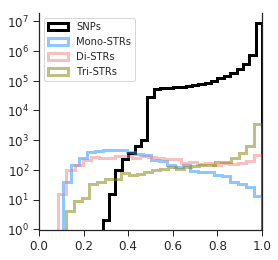

In [10]:
f, ax = subplots(ncols = 1, nrows = 1, figsize = (4,4))
linewidth = 3.0
bins = 25
color = 'Black'
a = 0.5
tick_params(direction='out', length=6, width=1)

hist(array(max_afs2), label = 'SNPs', color = 'Black', histtype='step', linewidth=linewidth, bins = bins)
hist(array(mono_mafs), label = 'Mono-STRs', color = mc, alpha = a, histtype='step', linewidth=linewidth, bins = bins)
hist(array(di_mafs), label = 'Di-STRs', histtype='step', color = dc, alpha = a, linewidth=linewidth, bins = bins)
hist(array(tri_mafs), label = 'Tri-STRs', histtype='step', color = tc, alpha = a, linewidth=linewidth, bins = bins)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(True)
legend(loc = 'upper left', fontsize = 10, frameon = True)
xlim(0, 1)
yscale('log', nonposy='clip')
xticks(fontsize = 12)
yticks(fontsize = 12)


savefig('../Figures/Arabidopsis_MAF_hist_w_snps.png', type = 'png', dpi = 500, transparent = True)
savefig('../Figures/Arabidopsis_MAF_hist_w_snps.pdf', type = 'pdf', transparent = True)


show()

### Figure 1.c

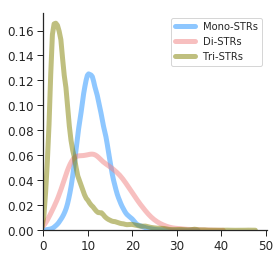

In [11]:
from seaborn import kdeplot, distplot
f, ax = subplots(ncols = 1, nrows = 1, figsize = (4,4))
lw = 5

tick_params(direction='out', length=6, width=1)

a = 0.5

distplot(mono_var, hist = False,
        kde_kws = {"color": mc, "lw": lw, 'label' : 'Mono-STRs', 'alpha' : a})
distplot(di_var, hist = False,
        kde_kws = {"color": dc, "lw": lw, 'label' : 'Di-STRs', 'alpha' : a})

distplot(tri_var, hist = False,
        kde_kws = {"color": tc, "lw": lw, 'label' : 'Tri-STRs', 'alpha' : a})

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

xticks(fontsize = 12)
yticks(fontsize = 12)
legend(fontsize = 10, frameon = True)


xlim(0)
savefig('../Figures/Arabidopsis_N_variants.png', type = 'png', dpi = 500, transparent = True)
savefig('../Figures/Arabidopsis_N_variants.pdf', type = 'pdf', transparent = True)

show()

### Figure 1.d

Loading data

In [12]:
vSTRs = pd.read_table('../data/STRs_depth5_chr_start_maf09.annotated.tsv')
nvSTRs = pd.read_table('../data/STRs_depth5_chr_start_maf09_nv.annotated.tsv')

vSTRs = vSTRs[vSTRs['CHR_START'].isin(at_least_25)]
nvSTRs = nvSTRs[nvSTRs['CHR_START'].isin(at_least_25)]

In [13]:
keep = ['CDS', 'FIVE_PRIME_UTR', 'THREE_PRIME_UTR', 'SPANNING', 'PROMOTER', 'INTRON', 'NON_GENIC']
vSTRs = vSTRs[vSTRs['WHERE'].isin(keep)]
nvSTRs = nvSTRs[nvSTRs['WHERE'].isin(keep)]

v_mono = vSTRs[vSTRs['UNIT_N']==1]
v_di = vSTRs[vSTRs['UNIT_N']==2]
v_tri = vSTRs[vSTRs['UNIT_N']==3]

nv_mono = nvSTRs[nvSTRs['UNIT_N']==1]
nv_di = nvSTRs[nvSTRs['UNIT_N']==2]
nv_tri = nvSTRs[nvSTRs['UNIT_N']==3]

In [14]:
def get_bars(frame):
    D = Counter(frame.groupby(['CHR_START', 'WHERE']).std().reset_index().WHERE)
    return D

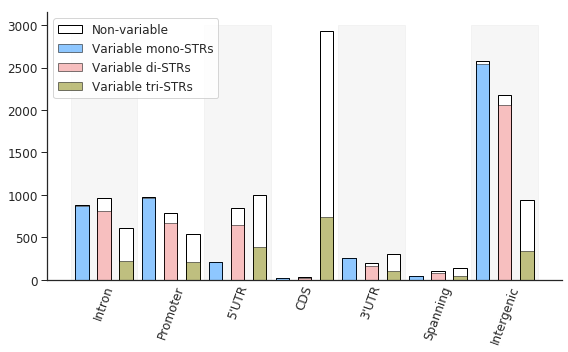

In [15]:
f, ax = subplots(figsize = (8, 5))

tick_params(direction='out', length=6, width=1, axis = 'y')


mono_data_v = array(get_bars(v_mono).values())
mono_data_nv = array(insert(get_bars(nv_mono).values(), 3, 0))

di_data_v = array(get_bars(v_di).values())
di_data_nv = array(get_bars(nv_di).values())

tri_data_v = array(get_bars(v_tri).values())
tri_data_nv = array(get_bars(nv_tri).values())

w = 0.2
a = 0.5

ax.bar(arange(0.33, len(get_bars(v_tri)) + 0.33), [3000, 0, 3000, 0, 3000, 0, 3000], color = 'lightgray', edgecolor = 'lightgray', width = 1, alpha = 0.2)


ax.bar(range(len(get_bars(v_mono))), mono_data_v + mono_data_nv, color = 'white', edgecolor = 'black', width = w, label = 'Non-variable')
ax.bar(range(len(get_bars(v_mono))), mono_data_v, color = mc, edgecolor = 'black', width = w, alpha = a, label = 'Variable mono-STRs')
ax.bar(arange(0.33, len(get_bars(v_di)) + 0.33), di_data_v + di_data_nv, color = 'white', edgecolor = 'black', width = w)
ax.bar(arange(0.33, len(get_bars(v_di)) + 0.33), di_data_v, color = dc, edgecolor = 'black', width = w, alpha = a, label = 'Variable di-STRs')
ax.bar(arange(0.66, len(get_bars(v_tri)) + 0.66), tri_data_v + tri_data_nv, color = 'white', edgecolor = 'black', width = w)
ax.bar(arange(0.66, len(get_bars(v_tri)) + 0.66), tri_data_v, color = tc, edgecolor = 'black', width = w, alpha = a, label = 'Variable tri-STRs')




ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
xlabels = ['Intron', 'Promoter', '5\'UTR', 'CDS', '3\'UTR', 'Spanning', 'Intergenic']
xticks(arange(0.33, 7), xlabels, fontsize = 12, rotation = 70)
yticks(fontsize = 12)
legend(fontsize = 12, frameon = True)

tight_layout()

savefig('../Figures/WhereAreSTRs_stacked_all.pdf', kind = 'pdf', transparent = True)
savefig('../Figures/WhereAreSTRs_stacked_all.png', kind = 'png', transparent = True)

show()

### Figure 1.e

First, mapping from DNA to protein coordinates

In [2]:
vSTRs = pd.read_table('../data/STRs_depth5_chr_start_maf09.annotated.tsv')
nvSTRs = pd.read_table('../data/STRs_depth5_chr_start_maf09_nv.annotated.tsv')
STR_data = pd.concat([vSTRs, nvSTRs])

STR_data_coding = STR_data[STR_data['WHERE'].isin(['CDS'])]

Making dictionary from TRF output with motifs and coordinates

In [4]:
fh = open('../data/TAIR10_cds_20101214_updated.new_headers.fasta.trf.output', 'r') # TRF output run on CDS only

TRF = fh.read()
fh.close()

motif_dict = {}
for i in TRF.split('@'):
    split = i.split('\n')
    if split != ['']:
        gene = str(split).split(' ')[0][2:]
        strand = str(split).split(' ')[1][0:-2]
        start_list = []
        motif_list = []       
        for element in split:
            new_split = element.split(' ')
            if len(new_split) == 17:
                start = new_split[0]
                end = new_split[1]
                motif = new_split[14]
                
                if strand == 'FORWARD':
                    motif_list.append([motif, start, end])
                else:
                    myseq = Seq(motif, generic_dna)
                    rev_seq = myseq.reverse_complement()

                    motif_list.append([rev_seq, end, start])
        motif_dict.update({gene : motif_list})

Making a BED file

In [6]:
fh = open('../data/TAIR10_cds_20101214_updated.new_headers.fasta.trf.output', 'r')
TRF = fh.read()
fh.close()

# Making dictionary with each gene as a key and the repeats within the gene in a list
TRF_dict = {}
for i in TRF.split('@'):
    split = i.split('\n')
    if split != ['']:
        gene = str(split[0]).split(' ')[0]
        repeats = split[1:len(split) - 1]
        repeat_list = []
        for repeat in repeats:
            if repeat.split()[2] == str(3):
                repeat_list.append(repeat.split(' ')[0:2])
        TRF_dict.update({gene : repeat_list})
        
# Making BED file
fh = open('../data/TAIR10_cds_20101214_updated.new_headers.fasta.trf.output.bed', 'w')
string = ''

tab = '\t'
for i in TRF_dict.keys():
    for k in TRF_dict[i]:
        start = (int(k[0])) / 3
        end = (int(k[1])) / 3
        string += i + tab + str(start) + tab + str(end) + tab + 'TNR' + tab + '+' + '\n'
fh.write(string)
fh.close()

In [34]:
exclude = []
for entry in motif_dict:
    i = motif_dict[entry]
    if len(i) > 1:
        motif_list = []
        for n in range(0, len(i), 1):
            motif_list.append(i[n][0])
        if len(motif_list) != len(set(motif_list)):
            exclude.append(entry)

In [10]:
# Making mapping file
fh = open('../data/cDNA_to_genomic_map_final.tsv', 'w')
string = ''
newline = '\n'
tab = '\t'
string += 'GENE' + tab + 'CDS_nuc_start' + tab + 'CDS_nuc_end' +  tab + 'CHR_START' + newline
for row in STR_data_coding.itertuples():
    # If the motif in the motif dictionary is equal to the motif in the repeat dataframe
    if row.GENE in motif_dict.keys() and row.GENE not in exclude:
        for motif in motif_dict[row.GENE]:
            if motif[0] == row.REF:
                motif_coord = []
                motif_coord.append(int(motif[1]))
                motif_coord.append(int(motif[2]))
                
                start = min(motif_coord)
                end = max(motif_coord)
                string += row.GENE + tab + str(start) + tab + str(end) + tab + str(row.CHR_START) + newline
fh.write(string)
fh.close()

In [19]:
cDNA_to_genomic_map_final = pd.read_table('../data/cDNA_to_genomic_map_final.tsv')
cDNA_to_genomic_map_final['Prot_start'] = [str(i.CDS_nuc_start / 3) for i in cDNA_to_genomic_map_final.itertuples()]
cDNA_to_genomic_map_final['Prot_end'] = [str(i.CDS_nuc_end / 3) for i in cDNA_to_genomic_map_final.itertuples()]

Using the TAIR10 peptide FASTA file to get dictionary with all repeats and their protein sequence

In [21]:
all_reps = {}
for i in cDNA_to_genomic_map_final.drop_duplicates().itertuples():
    for record in SeqIO.parse('../data/TAIR10_pep_20101214.txt', 'fasta'):
        if record.id == i.GENE:
            coord = [i.Prot_start, i.Prot_end]
            all_reps.update({str(i.CHR_START) + ' ' + str(coord[0]) + ' ' + str(coord[1]) : record.seq[int(i.Prot_start):int(i.Prot_end)+1]})

This takes a while, pickling results

In [22]:
pickle.dump(all_reps, open('../analysis/all_reps.dict', 'w'))

In [23]:
all_reps = pickle.load(open('../data/all_reps.dict', 'r'))

Getting loci to analyze

In [24]:
vSTR_loci = set(vSTRs[vSTRs['CHR_START'].isin([i.split()[0] for i in all_reps.keys()])].CHR_START)
nvSTR_loci = set(nvSTRs[nvSTRs['CHR_START'].isin([i.split()[0] for i in all_reps.keys()])].CHR_START)

Making new dictionaries and lists for plotting

In [25]:
d = {k.split()[0]: all_reps[k] for k in all_reps}
v_dict = {k: d[k] for k in vSTR_loci}
nv_dict = {k: d[k] for k in nvSTR_loci}

vAAs = []
for i in v_dict.values():
    if Counter(i).most_common(1)[0][0] * len(i[1:-1]) in i[1:-1]:
        print i
        vAAs.append(Counter(i).most_common(1)[0][0])

nvAAs = []
for i in nv_dict.values():
    if Counter(i).most_common(1)[0][0] * len(i[1:-1]) in i[1:-1]:
        print i
        nvAAs.append(Counter(i).most_common(1)[0][0])

SSSSSSSS
SSSSSSP
RGGGGGM
DDDDDDDV
PSSSSSSSS
QQQQQQQQQQQQQQQQQQQQQQE
QQQQQQQA
RRRRR
TTTTTT
SSSSSSS
LFFFFFF
NNNNNS
PPPPPPP
LVVVVE
ASSSSSSS
LLLLLT
SSSSSSSSSS
QQQQQQL
KKKKN
ASSSSS
DDDDDDDDQ
QQQQQQQP
FLLLLLLV
EEEEEEE
NDDDDDDDE
SSSSSSSS
PPPPPL
HDDDDDDI
GGGGGGG
TSSSSST
TSSSSSSSY
CGGGGGGG
SSSSSSSP
NNNNNNNT
EQQQQQQQQQQQQQQQQR
EEEEEEEEEED
KEEEEEEG
EEEEEEEEV
KKKKKKN
QQQQQQQM
EEEEEED
PSSSSSSSSSS
PPPPPPPPPPPPS
ASSSSSSSSSSS
SSSSSS
NNNNNNNNNNN
DDDDDDDDDDD
GGGGGGGP
EEEEEED
SSSSSSSSSSF
PPPPPPPP
QQQQQQQQQQM
SSSSSSY
DDDDDI
GGGGGGGGG
DDDDDDDDS
NNNNNA
DDDDDDDDDD
HNNNNNNNT
QQQQQQQK
EEEEEED
ASSSSSSS
KKKKKKV
PSSSSS
IFFFF
NNNNNNH
EEEEEEEEEED
PSSSSSSSSS
GGGGGGN
KEEEEEER
SSSSSSSSSSSS
FFFFFFFD
QQQQQQ
NNNNNP
EQQQQQS
EEEEEEEEEEEEEEEEEED
TTTTTTTK
EEEEEEG
MMMMMQ
GGGGGGGS
NNNNNNNK
EQQQQQQQQQQQ
QQQQQQQQQQQQQD
EEEEEET
QQQQQQQQ
TTTTTTM
QQQQQQH
PPPPPPP
NNNNNNNNNNND
YHHHHHHQ
GGGGGG
QQQQQR
EKKKKKK
KKKKKS
EEEEEEEP
FLLLLLS
GGGGGS
EEEEEES
DNNNNNT
KEEEEEEEG
QQQQQQQH
DDDDDD
ASSSSSSSS
ASSSSSS
LFFFF
SSSSSSSSSM
VFFFFFL
SPPPPPPT
NNN

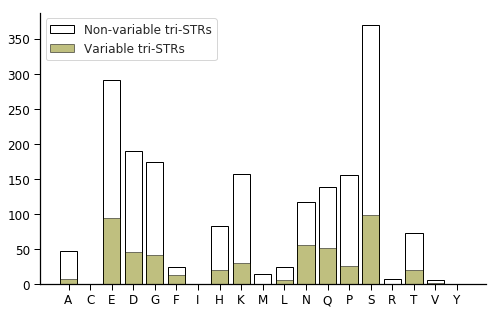

In [33]:
f, ax = subplots(figsize = (8,5))
Total = array(Counter(vAAs)) + array(Counter(nvAAs))
vAA = Counter(vAAs)
color = 'black'

tick_params(direction='out', length=6, width=1, axis = 'both')


setp(ax.spines.values(), color=color)
setp([ax.get_xticklines(), ax.get_yticklines()], color=color)
ax.bar(range(len(Total)), Total.values(), align = 'center', color = 'white', 
       label = 'Non-variable tri-STRs', linewidth = 1, edgecolor = 'Black')
ax.bar(range(len([vAA[key] for key in Total.keys()])), [vAA[key] for key in Total.keys()], alpha = 0.5, align = 'center', color = tc, 
       label = 'Variable tri-STRs', linewidth = 1, edgecolor = 'Black')


xticks(range(len(Total)), Total.keys())
xticks(color = color)
yticks(color = color)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xticklabels(ax.get_xticklabels(), size=12)
ax.set_yticklabels([int(x) for x in ax.get_yticks()], size=12)




legend(fontsize = 12, frameon = True)
#tight_layout()
savefig('../Figures/vAAs_nvAAs.pdf', type = 'pdf', transparent = True)
savefig('../Figures/vAAs_nvAAs.png', type = 'png', transparent = True)

show()